# Important Frequencies Selection

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [103]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import matplotlib.pyplot as plt
import graphviz 
import pickle
from mpl_toolkits.mplot3d import Axes3D

from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA, FastICA, IncrementalPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier

from scipy.stats import zscore
from scipy.signal import savgol_filter

# LSTM Model imports
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

# import wandb

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return seed

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set seed for reproducibility
seed = set_seed(42)

# Get the current directory of the notebook
notebook_dir = os.getcwd()


Using device: cpu


In [49]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

### Preprocessing Data
Function to preprocess the data. 

In [50]:
def calculate_averages_and_dispersion(df, data_percentage):

    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)
    # results_df.to_csv(output_file, sep=';', index=False)
    # print(f"Processed {input_file} and saved to {output_file}")
    # print(results_df)
    return results_df

### Pivoting Frequency values to columns

In [106]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    if data_percentage > 0:
        # 1s window_size 100/27s = 3.7% of the data is used for each window
        df_window = calculate_averages_and_dispersion(df, data_percentage) 

        # Add a unique identifier column to avoid duplicate entries in the index
        df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

        # Pivot the DataFrame to wide format
        df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

        # Flatten the MultiIndex columns - Ordered by Frequency + (HG mean, HG std deviation, LG mean, LG std deviation)
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]

        # Drop columns with all NaN values
        df_pivot = df_pivot.dropna(axis=1, how='all')

        # Reset index to make 'Sample' and 'unique_id' columns again
        df_pivot = df_pivot.reset_index()

        # Remove 'unique_id' column
        df_pivot = df_pivot.drop(columns=['unique_id'])
    else:
        # If data_percentage is 0, do not calculate mean and std deviation, use the original data
        df['unique_id'] = df.groupby(['Sample', 'Frequency (GHz)']).cumcount()
        df_pivot = df.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]
        df_pivot = df_pivot.dropna(axis=1, how='all')
        df_pivot = df_pivot.reset_index()
        df_pivot = df_pivot.drop(columns=['unique_id'])

    # Optional - Sort the columns if needed
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    return df_pivot

In [52]:
# Load the data from the directory
input_path = os.path.normpath(os.path.join(notebook_dir, '..', '..', '..', 'data/experiment_5_plastics/processed'))

df = load_data_from_directory(input_path)

df = pd.concat([df[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df[['Sample']]], axis=1)

df_ori = df.copy()

# Find if value samples have '_' in the name and remove everything after '_' 
# df['Sample'] = df['Sample'].str.split('_').str[0]
df['Sample'] = df['Sample'].str[0]

df.head(4)

,Frequency (GHz),LG (mV),HG (mV),Sample
0,100.0,0.366256,24.172872,A
1,100.0,-0.244170,37.846416,A
2,100.0,-1.831278,42.241484,A
3,100.0,1.220852,36.015138,A


## Balance Dataset

In [53]:
# Balance the data by taking the mode of samples per frequency
mean= int(df.groupby(['Sample', 'Frequency (GHz)']).size().mean())
print(f'Mean value: {mean}')


# Function to reduce samples to the mean value
def reduce_to_mean(df, sample, frequency, mean):
    # Filter the DataFrame for the specific sample and frequency
    freq_df = df[(df['Sample'] == sample) & (df['Frequency (GHz)'] == frequency)]
    # If the number of samples is greater than the mean, sample down to the mean
    if len(freq_df) > mean:
        return freq_df.sample(n=mean, random_state=42)
    return freq_df

# Apply the function to reduce samples for each combination of Sample and Frequency (GHz)
balanced_data = []
for (sample, frequency), group in df.groupby(['Sample', 'Frequency (GHz)']):
    balanced_data.append(reduce_to_mean(df, sample, frequency, mean))

# Combine the balanced samples into a single DataFrame
df_balanced = pd.concat(balanced_data)


Mean value: 5073


KeyboardInterrupt: 

### Sample a test set

In [54]:
df_train = df_balanced.copy()

test_percentage = 0.2

# # Shuffle the data
# df_train = df_train.sample(frac=1, random_state=42)

train_set, test_set = train_test_split(df_train, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set

train_set.head()


,Frequency (GHz),LG (mV),HG (mV),Sample
1231203,410.0,-0.366256,257.111466,E
2326649,580.0,-0.854596,35.648882,J
1455196,210.0,4.639238,0.488353,F
3037956,550.0,0.976682,43.096080,O
1519707,270.0,0.732511,-0.366259,G


### Data Windowing

In [55]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
stabilised_time_s = 12 * 4
data_percentage = (100/(stabilised_time_s*(1-test_percentage))) * time_window_s
data_percentage_test = (100/(stabilised_time_s*(test_percentage))) * time_window_s

# data_percentage = 100
# data_percentage_test = 100

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Load just a % of the data
# df_sample = train_set.sample(frac=0.02, random_state=42)

# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage_test)


# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()


Data percentage: 0.26041666666666663%
Data percentage test: 1.0416666666666665%


## Prepare Training Data
### Split data into X and y


In [56]:
def preprocess_data(df, labels, freqs, eliminate_std_dev=False, eliminate_LG=False, drop_sample=True):
    # Reduce number of different samples for testing
    X_ = df[df['Sample'].isin(labels)]

    y_ = X_['Sample']

    if drop_sample:
        X_ = X_.drop(columns=['Sample'])
        
    if freqs:
        # Subset of specific frequencies to use as input features (or without mean)
        columns = [f'{freq}.0 HG (mV) mean' for freq in freqs] + \
                  [f'{freq}.0 LG (mV) mean' for freq in freqs] + \
                  [f'{freq}.0 HG (mV)' for freq in freqs] + \
                  [f'{freq}.0 LG (mV)' for freq in freqs] + \
                  [f'{freq}.0 HG (mV) std deviation' for freq in freqs] + \
                  [f'{freq}.0 LG (mV) std deviation' for freq in freqs] + \
                  ['Sample']


        # Filter columns that exist in X_
        existing_columns = [col for col in columns if col in X_.columns]

        # Check if existing_columns is empty
        if not existing_columns:
            print("No matching columns found in X_.")
        else:
            X_ = X_[existing_columns]

        # Sort columns by frequency value
        X_ = X_.reindex(sorted(X_.columns), axis=1)

    if eliminate_std_dev:
        # Eliminate std dev columns from the input features
        X_ = X_.drop(columns=[col for col in X_.columns if 'std deviation' in col])

    if eliminate_LG:
        # Eliminate LG columns from the input features
        X_ = X_.drop(columns=[col for col in X_.columns if 'LG' in col])

    return X_, y_


### Define Models
- Random Forest
- Naive-Bayes
- Logistic Regression
- Gradient Boosting

In [57]:
def random_forest_model(X_train, y_train, seed):
    rf_model = RandomForestClassifier(random_state=seed)
    rf_model.fit(X_train, y_train)
    return rf_model

def naive_bayes_model(X_train, y_train):
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    return nb_model

def logistic_regression_model(X_train, y_train, seed):
    lr_model = LogisticRegression(max_iter=1000,
                                  random_state=seed)
    lr_model.fit(X_train, y_train)
    return lr_model

def gradient_boosting_model(X_train, y_train, seed):
    gb_model = GradientBoostingClassifier(random_state=seed)
    gb_model.fit(X_train, y_train)
    return gb_model

def support_vector_machine_model(X_train, y_train, seed):
    svm_model = SVC(random_state=seed)
    svm_model.fit(X_train, y_train)
    return svm_model


### Train all Models

In [58]:
def train_models(X_train, y_train, seed):
    rf_model = random_forest_model(X_train, y_train, seed)
    nb_model = naive_bayes_model(X_train, y_train)
    lr_model = logistic_regression_model(X_train, y_train, seed)
    gb_model = gradient_boosting_model(X_train, y_train, seed)
    svm_model = support_vector_machine_model(X_train, y_train, seed)
    return rf_model, nb_model, lr_model, gb_model, svm_model

def save_models(rf_model, nb_model, lr_model, gb_model, svm_model):
    joblib.dump(rf_model, 'random_forest_model.pkl')
    joblib.dump(nb_model, 'naive_bayes_model.pkl')
    joblib.dump(lr_model, 'logistic_regression_model.pkl')
    joblib.dump(gb_model, 'gradient_boosting_model.pkl')
    joblib.dump(svm_model, 'support_vector_machine_model.pkl')


In [59]:
# Function to apply confidence threshold
def apply_confidence_threshold(probabilities, threshold=0.7):
    max_probs = np.max(probabilities, axis=1)
    predictions = np.argmax(probabilities, axis=1)
    # Replace predictions with -1 (unknown) where confidence is below threshold
    predictions[max_probs < threshold] = -1
    return predictions, max_probs


In [60]:
# AIC Criteria
def aic_score(y_true, y_pred, n_features):
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals**2)
    epsilon = 1e-10  # Small value to avoid log(0)
    aic = 2 * n_features + n * np.log((rss + epsilon) / n)
    return aic

# BIC Criteria (Also consider the number of samples)
def bic_score(y_true, y_pred, n_features):
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals**2)
    epsilon = 1e-10  # Small value to avoid log(0)
    bic = np.log(n) * n_features + n * np.log((rss + epsilon) / n)
    return bic

In [61]:
def save_model_results(models, data, accuracies, precisions, recalls, f1_scores, predictions, n_features, freqs, 
                      aic_scores, bic_scores, csv_path='comparison_results.csv', verbose=0):
    
    # Determine test number
    if os.path.exists(csv_path):
        existing_results = pd.read_csv(csv_path, sep=';')
        current_test = existing_results['Test'].max() + 1
    else:
        current_test = 1

    # Create results DataFrame
    results_df = pd.DataFrame({
        'Test': [current_test] * len(models),
        'Data': [data] * len(models),
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1-Score': f1_scores,
        'AIC': aic_scores,
        'BIC': bic_scores,
        'Predictions': predictions,
        'Algorithm': models,
        'Num_Features': [n_features] * len(models),
        'Num Frequencies': [len(freqs)] * len(models),
        'Frequencies': [', '.join([f"{freq:.0f}" for freq in freqs])] * len(models)
    })

    # Format float columns
    float_columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AIC', 'BIC']
    results_df[float_columns] = results_df[float_columns].round(4)

    # Append or create results file
    if os.path.exists(csv_path):
        updated_results = pd.concat([existing_results, results_df], ignore_index=True)
    else:
        updated_results = results_df

    # Save updated results
    updated_results.to_csv(csv_path, index=False, sep=';')

    if verbose >= 1:
        print(f"\nTest #{current_test} Results:")
        print(results_df)
        if verbose >= 2:
            print("\nAll Results:")
            print(updated_results)
        
    return updated_results

In [62]:
def evaluate_models(y_test, y_pred, verbose=0):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    aic_scores = []
    bic_scores = []
    predictions_list = []

    # Label encode y_test
    le = LabelEncoder()
    le.fit(y_test)

    for i, y_pred_i in enumerate(y_pred):
        accuracy = accuracy_score(y_test, y_pred_i)
        precision = precision_score(y_test, y_pred_i, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred_i, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred_i, average='weighted', zero_division=0)

        # Calculate AIC and BIC
        y_test_num = le.transform(y_test)
        y_pred_num = le.transform(y_pred_i)
        n_features = len(y_pred_i)
        aic = aic_score(y_test_num, y_pred_num, n_features)
        bic = bic_score(y_test_num, y_pred_num, n_features)

        # Predictions made per class with its label encoded value
        predictions = dict(sorted(Counter(y_pred_i).items()))

        print(f"Model {i+1} - Accuracy: {accuracy}")

        if verbose >= 1:
            print(f"Model {i+1} - Precision: {precision}")
            print(f"Model {i+1} - Recall: {recall}")
            print(f"Model {i+1} - F1: {f1}")
            print(f"Model {i+1} - AIC: {aic}")
            print(f"Model {i+1} - BIC: {bic}")
            print(f"Model {i+1} - Predictions: {predictions}\n")
            if verbose >= 2:
                # Classification report
                print(f"Model {i+1} - Classification Report:\n", classification_report(y_test, y_pred_i), '\n')


        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        aic_scores.append(aic)
        bic_scores.append(bic)
        predictions_list.append(predictions)

    return accuracies, precisions, recalls, f1_scores, aic_scores, bic_scores, predictions_list

In [63]:
def get_feature_importances(rf_model, lr_model, gb_model, nb_model, X_train, y_train, seed, plot=False, n=30):
    feature_names = X_train.columns

    # Random Forest feature importances
    rf_feature_importances = rf_model.feature_importances_
    rf_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_feature_importances})
    rf_feature_importances_df = rf_feature_importances_df.sort_values('Importance', ascending=False)

    # Logistic Regression feature importances
    lr_feature_importances = lr_model.coef_[0]
    lr_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': lr_feature_importances})
    lr_feature_importances_df = lr_feature_importances_df.sort_values('Importance', ascending=False)

    # Gradient Boosting feature importances
    gb_feature_importances = gb_model.feature_importances_
    gb_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': gb_feature_importances})
    gb_feature_importances_df = gb_feature_importances_df.sort_values('Importance', ascending=False)

    # Naive Bayes permutation importance
    result = permutation_importance(nb_model, X_train, y_train, n_repeats=5, random_state=seed, n_jobs=1)
    sorted_idx = result.importances_mean.argsort()[::-1]
    nb_feature_importances_df = pd.DataFrame({'Feature': feature_names[sorted_idx], 'Importance': result.importances_mean[sorted_idx]})

    if plot:
        # Font size
        plt.rcParams.update({'font.size': 6})

        # Plot the feature importances
        plt.figure(figsize=(20, 10))
        plt.barh(rf_feature_importances_df['Feature'][:n], rf_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Random Forest Feature Importances')
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.barh(lr_feature_importances_df['Feature'][:n], lr_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Logistic Regression Feature Importances')
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.barh(gb_feature_importances_df['Feature'][:n], gb_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Gradient Boosting Feature Importances')
        plt.show()

        plt.figure(figsize=(12, 8))
        plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
        plt.xlabel('Permutation Importance')
        plt.title('Naive Bayes Permutation Feature Importance')
        plt.show()

    return rf_feature_importances_df, lr_feature_importances_df, gb_feature_importances_df, nb_feature_importances_df


### Confusion Matrix

In [64]:
## Confusion matrix with matplotlib
def plot_confusion_matrix(y_true, y_pred, labels):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix, axis=1)[i] * 100:.1f}%)',
                     horizontalalignment="center",
                     verticalalignment="center",
                     fontsize=7, 
                     ha='center', va='center', color='white')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(labels)), labels, rotation=45)
    plt.yticks(np.arange(len(labels)), labels)
    plt.title('Confusion Matrix')
    plt.show()


In [65]:
def add_features(X, y, subset_freqs, HG_diff=True, LG_diff=True):

    X['Sample'] = y

    # Initialize a dictionary to store results
    mean_std_dict = {}

    for freq in subset_freqs:
        # Calculate HG and LG mean values for each frequency
        agg_dict = {}
        if f'{freq}.0 LG (mV) mean' in X.columns:
            agg_dict['LG_mean'] = (f'{freq}.0 LG (mV) mean', 'mean')
        if f'{freq}.0 HG (mV) mean' in X.columns:
            agg_dict['HG_mean'] = (f'{freq}.0 HG (mV) mean', 'mean')
        
        mean_std_dict[freq] = X.groupby('Sample').agg(**agg_dict).reset_index()

        mean_std_dict[freq]['Frequency'] = freq

    # Concatenate all DataFrames in the dictionary
    mean_std_df = pd.concat(mean_std_dict.values(), ignore_index=True)

    # For each frequency after first one
    for i, freq in enumerate(subset_freqs[1:]):
        prev_freq = subset_freqs[i]  # Get previous frequency
        
        # For each row
        for idx, row in X.iterrows():
            sample = row['Sample']
            
            if HG_diff:
                # Get previous frequency's HG mean for this sample
                prev_hg = mean_std_df[
                    (mean_std_df['Frequency'] == prev_freq) & 
                    (mean_std_df['Sample'] == sample)
                ]['HG_mean'].values[0]


                # 1) Inputs: xt - (xt-1) --First-order differences
                # 2) Inputs: (xt/(xt-1)) - 1 --Escalado relativo

                # Calculate and store difference
                X.loc[idx, f'{freq}.0 HG diff'] = X.loc[idx, f'{freq}.0 HG (mV) mean'] - prev_hg
                # X.loc[idx, f'{freq}.0 HG relative diff'] = (X.loc[idx, f'{freq}.0 HG (mV) mean'] / prev_hg) -1


            if LG_diff:
                prev_lg = mean_std_df[
                    (mean_std_df['Frequency'] == prev_freq) & 
                    (mean_std_df['Sample'] == sample)
                ]['LG_mean'].values[0]

                # Calculate and store difference
                # X.loc[idx, f'{freq}.0 LG diff'] = X.loc[idx, f'{freq}.0 LG (mV) mean'] - prev_lg
                X.loc[idx, f'{freq}.0 LG relative diff'] = (X.loc[idx, f'{freq}.0 LG (mV) mean'] / prev_lg) -1


    # Drop the 'Sample' column
    X = X.drop(columns=['Sample'])

    return X
  

### Load New Test Data
Prepare new sample for testing (Testing other samples, out of initial dataset)

In [66]:
input_path = os.path.normpath(os.path.join(notebook_dir, '..', '..', '..', 'data/experiment_5_plastics/processed/new_sample'))

df_new_sample = load_data_from_directory(input_path)
df_new_sample = pd.concat([df_new_sample[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df_new_sample[['Sample']]], axis=1)

df_new_sample['Sample'] = df_new_sample['Sample'].str[0]
print(df_new_sample.head(10))

# Calculate the percentage of data used for each window
time_window_s = 0.1
stabilised_time_s = 12 * 1
data_percentage = (100/(stabilised_time_s*(1-test_percentage))) * time_window_s
data_percentage_test = (100/(stabilised_time_s*(test_percentage))) * time_window_s

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Introduce Frequency values as input variables
df_new_sample = freq_as_variable(df_new_sample, data_percentage) # 0.22

# If a row has any NaN value, remove that row
df_new_sample = df_new_sample.dropna()

print(f"New sample shape: {df_new_sample.shape}")
# print(f"X_shape: {X_train.shape}")

# le = LabelEncoder()

# # save label encoder
# joblib.dump(le, 'label_encoder.pkl')

# # load the label encoder
# le = joblib.load('label_encoder.pkl')

   Frequency (GHz)   LG (mV)    HG (mV) Sample
0            100.0 -1.098767  45.659870      A
1            100.0 -0.854596  32.718837      A
2            100.0 -1.220852  22.829935      A
3            100.0  0.610426  37.846416      A
4            100.0 -0.488341  20.266145      A
5            100.0 -0.244170  22.463679      A
6            100.0 -0.732511  24.539128      A
7            100.0 -1.465023  28.934196      A
8            100.0 -0.488341  25.882065      A
9            100.0  1.098767  46.026126      A
Data percentage: 1.0416666666666665%
Data percentage test: 4.166666666666666%
New sample shape: (1158, 201)


## Define training and testing data

In [74]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'O']
# labels = [ 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'L', 'O']


# Subset of specific frequencies to use as input features, If freqs = [] then all frequencies are used

# Favourite frequencies
freqs_fav = [250,300,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540]
freqs_fav_2 = [340,350,360,370,380,390,400,410,420]
freqs_fav_3 = [310,320,330,340,350,360,370,380,390,400,410,420]


# # Count number of frequencies
# print(f'freqs number: {len(freqs)}')

# Array with subsets of frequencies to use for training
freqs = [
        [250, 300, 320],
        [330, 340, 350],
        [360, 370, 380],
        [390, 400, 410],
        [420, 430, 440],
        [450, 460, 470],
        [480, 490, 500],
        [510, 520, 530, 540]
    ]

freqs.append(freqs_fav)
freqs.append(freqs_fav_2)
freqs.append(freqs_fav_3)

# # Add all frequencies one by one
# for i in range(250, 591, 10):
#     freqs.append([i])

# Add groups of 2 frequencies
for i in range(340, 351, 20):
    if i + 10 <= 350:
        freqs.append([i, i+10])

# Add groups of 3 frequencies
for i in range(250, 591, 30):
    if i + 20 <= 590 and i + 10 <= 590:
        freqs.append([i, i+10, i+20])

# Add a group with all frequencies from 100 to 590
freqs.append(list(range(100, 591, 10)))

freqs.append([250,320,330,410])

# freqs = freqs_fav ## TESTING

print(freqs)

[[250, 300, 320], [330, 340, 350], [360, 370, 380], [390, 400, 410], [420, 430, 440], [450, 460, 470], [480, 490, 500], [510, 520, 530, 540], [250, 300, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540], [340, 350, 360, 370, 380, 390, 400, 410, 420], [310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420], [340, 350], [250, 260, 270], [280, 290, 300], [310, 320, 330], [340, 350, 360], [370, 380, 390], [400, 410, 420], [430, 440, 450], [460, 470, 480], [490, 500, 510], [520, 530, 540], [550, 560, 570], [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590], [250, 320, 330, 410]]


In [68]:
def inference_sampling(predictions):
    """
    Takes a list of predictions and returns the most common value
    Args: predictions: List of prediction values
    Returns: Most frequent prediction value
    """
    if not predictions:
        return None
        
    # Count frequency of each prediction
    freq_dict = {}
    for pred in predictions:
        freq_dict[pred] = freq_dict.get(pred, 0) + 1
    
    # Find value with highest frequency
    max_freq = 0
    mode = None
    for value, freq in freq_dict.items():
        if freq > max_freq:
            max_freq = freq
            mode = value
            
    return mode

In [69]:
def predict_with_probabilities(model, X):
    """
    Perform inference on the dataset using the trained model and return predictions with probabilities.

    Parameters:
    model: Trained model object with predict and predict_proba methods.
    X: Dataset to perform inference on.

    Returns:
    predictions: Array of predicted class labels.
    probabilities: Array of predicted probabilities for each class.
    """
    # Predict class labels
    predictions = model.predict(X)
    
    # Predict probabilities
    probabilities = model.predict_proba(X)
    
    return predictions, probabilities

In [70]:
def evaluate_models_with_sampling(models, X, y_true):
    """
    Evaluate multiple models using inference sampling
    
    Args:
        models: List of trained model objects
        X: Features dataset
        y_true: True labels
        
    Returns:
        Dictionary with evaluation metrics
    """
        
    # Get predictions from each model
    all_predictions = []
    for model in models:
        preds, _ = predict_with_probabilities(model, X)
        all_predictions.append(preds)
    
    # Get final predictions using sampling
    final_predictions = []
    for i in range(len(X)):
        sample_preds = [pred[i] for pred in all_predictions]
        final_pred = inference_sampling(sample_preds)
        final_predictions.append(final_pred)
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_true, final_predictions),
        'precision': precision_score(y_true, final_predictions, average='weighted'),
        'recall': recall_score(y_true, final_predictions, average='weighted'),
        'f1': f1_score(y_true, final_predictions, average='weighted')
    }
    
    return metrics

## Testing

Training
Frequency: [250, 300, 320]


c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9275862068965517
Model 2 - Accuracy: 0.9086206896551724
Model 3 - Accuracy: 0.8836206896551724
Model 4 - Accuracy: 0.9155172413793103
Model 5 - Accuracy: 0.9060344827586206
Model 1 - Accuracy: 0.33074265975820377
Model 2 - Accuracy: 0.28324697754749567
Model 3 - Accuracy: 0.3229706390328152
Model 4 - Accuracy: 0.2694300518134715
Model 5 - Accuracy: 0.4844559585492228
Model 1 - Accuracy: 0.9706643658326143
Model 2 - Accuracy: 0.9447799827437446
Model 3 - Accuracy: 0.9413287316652287
Model 4 - Accuracy: 0.9628990509059534
Model 5 - Accuracy: 0.9663503019844694
Model 1 - Accuracy: 0.3488773747841105
Model 2 - Accuracy: 0.38255613126079446
Model 3 - Accuracy: 0.3393782383419689
Model 4 - Accuracy: 0.25215889464594127
Model 5 - Accuracy: 0.39723661485319517
Frequency: [330, 340, 350]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9974137931034482
Model 2 - Accuracy: 0.9982758620689656
Model 3 - Accuracy: 0.9974137931034482
Model 4 - Accuracy: 0.9982758620689656
Model 5 - Accuracy: 0.9982758620689656
Model 1 - Accuracy: 0.6269430051813472
Model 2 - Accuracy: 0.7746113989637305
Model 3 - Accuracy: 0.6493955094991365
Model 4 - Accuracy: 0.5656303972366149
Model 5 - Accuracy: 0.6666666666666666


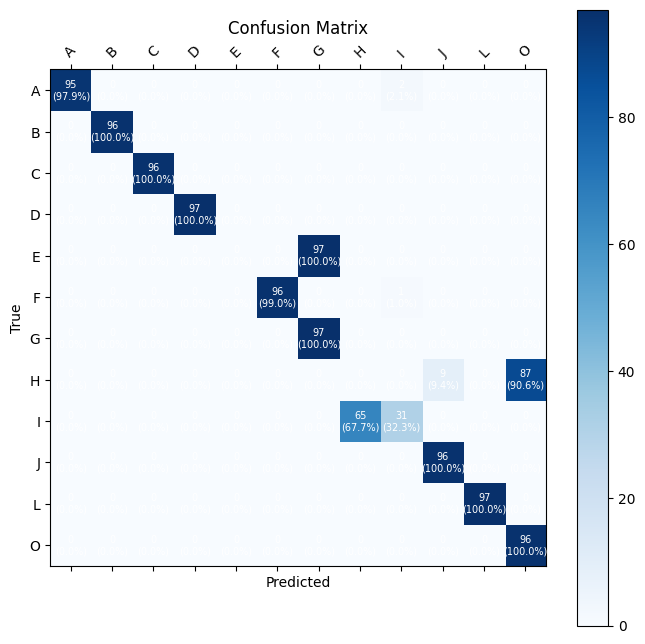

Model 1 - Accuracy: 1.0
Model 2 - Accuracy: 1.0
Model 3 - Accuracy: 0.994823123382226
Model 4 - Accuracy: 0.9922346850733391
Model 5 - Accuracy: 1.0
Model 1 - Accuracy: 0.5949913644214162
Model 2 - Accuracy: 0.5872193436960277
Model 3 - Accuracy: 0.43436960276338515
Model 4 - Accuracy: 0.5716753022452504
Model 5 - Accuracy: 0.5854922279792746
Frequency: [360, 370, 380]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9948275862068966
Model 2 - Accuracy: 0.9939655172413793
Model 3 - Accuracy: 0.9896551724137931
Model 4 - Accuracy: 0.9913793103448276
Model 5 - Accuracy: 0.9956896551724138
Model 1 - Accuracy: 0.6062176165803109
Model 2 - Accuracy: 0.6502590673575129
Model 3 - Accuracy: 0.6321243523316062
Model 4 - Accuracy: 0.5371329879101899
Model 5 - Accuracy: 0.6640759930915371
Model 1 - Accuracy: 0.9870578084555651
Model 2 - Accuracy: 0.9870578084555651
Model 3 - Accuracy: 0.9715271786022434
Model 4 - Accuracy: 0.9853321829163072
Model 5 - Accuracy: 0.9896462467644521
Model 1 - Accuracy: 0.7098445595854922
Model 2 - Accuracy: 0.5604490500863558
Model 3 - Accuracy: 0.5077720207253886
Model 4 - Accuracy: 0.5656303972366149
Model 5 - Accuracy: 0.6813471502590673
Frequency: [390, 400, 410]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9887931034482759
Model 2 - Accuracy: 0.9887931034482759
Model 3 - Accuracy: 0.9862068965517241
Model 4 - Accuracy: 0.9905172413793103
Model 5 - Accuracy: 0.9905172413793103
Model 1 - Accuracy: 0.4119170984455959
Model 2 - Accuracy: 0.29620034542314333
Model 3 - Accuracy: 0.27892918825561314
Model 4 - Accuracy: 0.39896373056994816
Model 5 - Accuracy: 0.2538860103626943
Model 1 - Accuracy: 0.9818809318377912
Model 2 - Accuracy: 0.9767040552200172
Model 3 - Accuracy: 0.9404659188955996
Model 4 - Accuracy: 0.9801553062985332
Model 5 - Accuracy: 0.9827437446074202
Model 1 - Accuracy: 0.33592400690846286
Model 2 - Accuracy: 0.24265975820379965
Model 3 - Accuracy: 0.344559585492228
Model 4 - Accuracy: 0.3281519861830743
Model 5 - Accuracy: 0.33506044905008636
Frequency: [420, 430, 440]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9793103448275862
Model 2 - Accuracy: 0.9724137931034482
Model 3 - Accuracy: 0.9637931034482758
Model 4 - Accuracy: 0.9801724137931035
Model 5 - Accuracy: 0.9767241379310345
Model 1 - Accuracy: 0.33506044905008636
Model 2 - Accuracy: 0.531951640759931
Model 3 - Accuracy: 0.4792746113989637
Model 4 - Accuracy: 0.3756476683937824
Model 5 - Accuracy: 0.48877374784110533
Model 1 - Accuracy: 0.9836065573770492
Model 2 - Accuracy: 0.9767040552200172
Model 3 - Accuracy: 0.9335634167385677
Model 4 - Accuracy: 0.9698015530629853
Model 5 - Accuracy: 0.9792924935289042
Model 1 - Accuracy: 0.28324697754749567
Model 2 - Accuracy: 0.42055267702936094
Model 3 - Accuracy: 0.3005181347150259
Model 4 - Accuracy: 0.3696027633851468
Model 5 - Accuracy: 0.39896373056994816
Frequency: [450, 460, 470]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9689655172413794
Model 2 - Accuracy: 0.9724137931034482
Model 3 - Accuracy: 0.9586206896551724
Model 4 - Accuracy: 0.9672413793103448
Model 5 - Accuracy: 0.971551724137931
Model 1 - Accuracy: 0.34024179620034545
Model 2 - Accuracy: 0.4378238341968912
Model 3 - Accuracy: 0.3471502590673575
Model 4 - Accuracy: 0.3531951640759931
Model 5 - Accuracy: 0.47322970639032813
Model 1 - Accuracy: 0.9654874892148404
Model 2 - Accuracy: 0.9637618636755824
Model 3 - Accuracy: 0.9292493528904228
Model 4 - Accuracy: 0.9637618636755824
Model 5 - Accuracy: 0.9646246764452114
Model 1 - Accuracy: 0.40500863557858374
Model 2 - Accuracy: 0.39810017271157166
Model 3 - Accuracy: 0.4274611398963731
Model 4 - Accuracy: 0.40932642487046633
Model 5 - Accuracy: 0.501727115716753
Frequency: [480, 490, 500]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9603448275862069
Model 2 - Accuracy: 0.9594827586206897
Model 3 - Accuracy: 0.9586206896551724
Model 4 - Accuracy: 0.9577586206896552
Model 5 - Accuracy: 0.9663793103448276
Model 1 - Accuracy: 0.34283246977547494
Model 2 - Accuracy: 0.36787564766839376
Model 3 - Accuracy: 0.25906735751295334
Model 4 - Accuracy: 0.3756476683937824
Model 5 - Accuracy: 0.35751295336787564
Model 1 - Accuracy: 0.9180327868852459
Model 2 - Accuracy: 0.917169974115617
Model 3 - Accuracy: 0.8386540120793787
Model 4 - Accuracy: 0.9214840379637619
Model 5 - Accuracy: 0.9283865401207938
Model 1 - Accuracy: 0.4006908462867012
Model 2 - Accuracy: 0.35578583765112265
Model 3 - Accuracy: 0.27806563039723664
Model 4 - Accuracy: 0.44991364421416236
Model 5 - Accuracy: 0.43955094991364424
Frequency: [510, 520, 530, 540]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9189655172413793
Model 2 - Accuracy: 0.9362068965517242
Model 3 - Accuracy: 0.9206896551724137
Model 4 - Accuracy: 0.9224137931034483
Model 5 - Accuracy: 0.9353448275862069
Model 1 - Accuracy: 0.3920552677029361
Model 2 - Accuracy: 0.39896373056994816
Model 3 - Accuracy: 0.4006908462867012
Model 4 - Accuracy: 0.42400690846286704
Model 5 - Accuracy: 0.4162348877374784
Frequency: [250, 300, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540]
Model 1 - Accuracy: 1.0
Model 2 - Accuracy: 1.0
Model 3 - Accuracy: 1.0
Model 4 - Accuracy: 0.9991379310344828
Model 5 - Accuracy: 1.0
Model 1 - Accuracy: 0.6632124352331606
Model 2 - Accuracy: 0.6675302245250432
Model 3 - Accuracy: 0.4214162348877375
Model 4 - Accuracy: 0.47668393782383417
Model 5 - Accuracy: 0.6459412780656304
Frequency: [340, 350, 360, 370, 380, 390, 400, 410, 420]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9982758620689656
Model 2 - Accuracy: 0.9991379310344828
Model 3 - Accuracy: 0.9991379310344828
Model 4 - Accuracy: 0.996551724137931
Model 5 - Accuracy: 0.9991379310344828
Model 1 - Accuracy: 0.5975820379965457
Model 2 - Accuracy: 0.6968911917098446
Model 3 - Accuracy: 0.4162348877374784
Model 4 - Accuracy: 0.4015544041450777
Model 5 - Accuracy: 0.5362694300518135
Model 1 - Accuracy: 0.9706643658326143
Model 2 - Accuracy: 0.9447799827437446
Model 3 - Accuracy: 0.9413287316652287
Model 4 - Accuracy: 0.9628990509059534
Model 5 - Accuracy: 0.9663503019844694
Model 1 - Accuracy: 0.3488773747841105
Model 2 - Accuracy: 0.38255613126079446
Model 3 - Accuracy: 0.3393782383419689
Model 4 - Accuracy: 0.25215889464594127
Model 5 - Accuracy: 0.39723661485319517
Frequency: [330, 340, 350]


c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 1.0
Model 2 - Accuracy: 1.0
Model 3 - Accuracy: 0.994823123382226
Model 4 - Accuracy: 0.9922346850733391
Model 5 - Accuracy: 1.0
Model 1 - Accuracy: 0.5949913644214162
Model 2 - Accuracy: 0.5872193436960277
Model 3 - Accuracy: 0.43436960276338515
Model 4 - Accuracy: 0.5716753022452504
Model 5 - Accuracy: 0.5854922279792746
Frequency: [360, 370, 380]


c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9870578084555651
Model 2 - Accuracy: 0.9870578084555651
Model 3 - Accuracy: 0.9715271786022434
Model 4 - Accuracy: 0.9853321829163072
Model 5 - Accuracy: 0.9896462467644521
Model 1 - Accuracy: 0.7098445595854922
Model 2 - Accuracy: 0.5604490500863558
Model 3 - Accuracy: 0.5077720207253886
Model 4 - Accuracy: 0.5656303972366149
Model 5 - Accuracy: 0.6813471502590673
Frequency: [390, 400, 410]


c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9818809318377912
Model 2 - Accuracy: 0.9767040552200172
Model 3 - Accuracy: 0.9404659188955996
Model 4 - Accuracy: 0.9801553062985332
Model 5 - Accuracy: 0.9827437446074202
Model 1 - Accuracy: 0.33592400690846286
Model 2 - Accuracy: 0.24265975820379965
Model 3 - Accuracy: 0.344559585492228
Model 4 - Accuracy: 0.3281519861830743
Model 5 - Accuracy: 0.33506044905008636
Frequency: [420, 430, 440]


c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9836065573770492
Model 2 - Accuracy: 0.9767040552200172
Model 3 - Accuracy: 0.9335634167385677
Model 4 - Accuracy: 0.9698015530629853
Model 5 - Accuracy: 0.9792924935289042
Model 1 - Accuracy: 0.28324697754749567
Model 2 - Accuracy: 0.42055267702936094
Model 3 - Accuracy: 0.3005181347150259
Model 4 - Accuracy: 0.3696027633851468
Model 5 - Accuracy: 0.39896373056994816
Frequency: [450, 460, 470]


c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9654874892148404
Model 2 - Accuracy: 0.9637618636755824
Model 3 - Accuracy: 0.9292493528904228
Model 4 - Accuracy: 0.9637618636755824
Model 5 - Accuracy: 0.9646246764452114
Model 1 - Accuracy: 0.40500863557858374
Model 2 - Accuracy: 0.39810017271157166
Model 3 - Accuracy: 0.4274611398963731
Model 4 - Accuracy: 0.40932642487046633
Model 5 - Accuracy: 0.501727115716753
Frequency: [480, 490, 500]


c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9180327868852459
Model 2 - Accuracy: 0.917169974115617
Model 3 - Accuracy: 0.8386540120793787
Model 4 - Accuracy: 0.9214840379637619
Model 5 - Accuracy: 0.9283865401207938
Model 1 - Accuracy: 0.4006908462867012
Model 2 - Accuracy: 0.35578583765112265
Model 3 - Accuracy: 0.27806563039723664
Model 4 - Accuracy: 0.44991364421416236
Model 5 - Accuracy: 0.43955094991364424
Frequency: [510, 520, 530, 540]


c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9068162208800691
Model 2 - Accuracy: 0.909404659188956
Model 3 - Accuracy: 0.8645383951682485
Model 4 - Accuracy: 0.8990509059534081
Model 5 - Accuracy: 0.9154443485763589
Model 1 - Accuracy: 0.40932642487046633
Model 2 - Accuracy: 0.43436960276338515
Model 3 - Accuracy: 0.44473229706390327
Model 4 - Accuracy: 0.41968911917098445
Model 5 - Accuracy: 0.4265975820379965
Frequency: [250, 300, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540]
Model 1 - Accuracy: 1.0
Model 2 - Accuracy: 1.0
Model 3 - Accuracy: 0.999137187230371
Model 4 - Accuracy: 0.996548748921484
Model 5 - Accuracy: 1.0
Model 1 - Accuracy: 0.6001727115716753
Model 2 - Accuracy: 0.5578583765112263
Model 3 - Accuracy: 0.5466321243523317
Model 4 - Accuracy: 0.5034542314335061
Model 5 - Accuracy: 0.697754749568221
Frequency: [340, 350, 360, 370, 380, 390, 400, 410, 420]
Model 1 - Accuracy: 0.999137187230371
Model 2 - Accuracy: 0.99913718723

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9775862068965517
Model 2 - Accuracy: 0.9862068965517241
Model 3 - Accuracy: 0.9827586206896551
Model 4 - Accuracy: 0.9810344827586207
Model 5 - Accuracy: 0.9844827586206897
Model 1 - Accuracy: 0.5846286701208981
Model 2 - Accuracy: 0.5958549222797928
Model 3 - Accuracy: 0.45509499136442144
Model 4 - Accuracy: 0.49568221070811747
Model 5 - Accuracy: 0.6295336787564767
Model 1 - Accuracy: 0.9792924935289042
Model 2 - Accuracy: 0.9844693701466781
Model 3 - Accuracy: 0.9430543572044866
Model 4 - Accuracy: 0.9827437446074202
Model 5 - Accuracy: 0.9827437446074202
Model 1 - Accuracy: 0.6649395509499136
Model 2 - Accuracy: 0.48272884283246975
Model 3 - Accuracy: 0.4481865284974093
Model 4 - Accuracy: 0.5872193436960277
Model 5 - Accuracy: 0.5941278065630398
Frequency: [250, 260, 270]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.6655172413793103
Model 2 - Accuracy: 0.6344827586206897
Model 3 - Accuracy: 0.6551724137931034
Model 4 - Accuracy: 0.6706896551724137
Model 5 - Accuracy: 0.618103448275862
Model 1 - Accuracy: 0.19516407599309155
Model 2 - Accuracy: 0.1303972366148532
Model 3 - Accuracy: 0.14680483592400692
Model 4 - Accuracy: 0.19170984455958548
Model 5 - Accuracy: 0.19343696027633853
Model 1 - Accuracy: 0.8567730802415876
Model 2 - Accuracy: 0.7765314926660914
Model 3 - Accuracy: 0.7463330457290768
Model 4 - Accuracy: 0.8559102674719585
Model 5 - Accuracy: 0.7920621225194133
Model 1 - Accuracy: 0.3488773747841105
Model 2 - Accuracy: 0.3842832469775475
Model 3 - Accuracy: 0.3298791018998273
Model 4 - Accuracy: 0.3609671848013817
Model 5 - Accuracy: 0.29965457685664937
Frequency: [280, 290, 300]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.5939655172413794
Model 2 - Accuracy: 0.6103448275862069
Model 3 - Accuracy: 0.6017241379310345
Model 4 - Accuracy: 0.6094827586206897
Model 5 - Accuracy: 0.6112068965517241
Model 1 - Accuracy: 0.17530224525043178
Model 2 - Accuracy: 0.15889464594127806
Model 3 - Accuracy: 0.1770293609671848
Model 4 - Accuracy: 0.15457685664939552
Model 5 - Accuracy: 0.17443868739205526
Model 1 - Accuracy: 0.7903364969801553
Model 2 - Accuracy: 0.7739430543572045
Model 3 - Accuracy: 0.7238999137187231
Model 4 - Accuracy: 0.7946505608283002
Model 5 - Accuracy: 0.6842105263157895
Model 1 - Accuracy: 0.21502590673575128
Model 2 - Accuracy: 0.21502590673575128
Model 3 - Accuracy: 0.14766839378238342
Model 4 - Accuracy: 0.23661485319516407
Model 5 - Accuracy: 0.14335060449050085
Frequency: [310, 320, 330]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.993103448275862
Model 2 - Accuracy: 0.9922413793103448
Model 3 - Accuracy: 0.993103448275862
Model 4 - Accuracy: 0.9913793103448276
Model 5 - Accuracy: 0.9974137931034482
Model 1 - Accuracy: 0.37737478411053543
Model 2 - Accuracy: 0.45768566493955093
Model 3 - Accuracy: 0.26424870466321243
Model 4 - Accuracy: 0.26252158894645944
Model 5 - Accuracy: 0.37132987910189985
Model 1 - Accuracy: 0.9853321829163072
Model 2 - Accuracy: 0.9801553062985332
Model 3 - Accuracy: 0.9792924935289042
Model 4 - Accuracy: 0.9887834339948232
Model 5 - Accuracy: 0.9870578084555651
Model 1 - Accuracy: 0.4058721934369603
Model 2 - Accuracy: 0.5578583765112263
Model 3 - Accuracy: 0.24438687392055267
Model 4 - Accuracy: 0.4680483592400691
Model 5 - Accuracy: 0.4283246977547496
Frequency: [340, 350, 360]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9982758620689656
Model 2 - Accuracy: 0.9982758620689656
Model 3 - Accuracy: 0.9982758620689656
Model 4 - Accuracy: 0.9991379310344828
Model 5 - Accuracy: 0.9982758620689656
Model 1 - Accuracy: 0.5613126079447323
Model 2 - Accuracy: 0.7452504317789291
Model 3 - Accuracy: 0.46718480138169255
Model 4 - Accuracy: 0.35664939550949915
Model 5 - Accuracy: 0.6044905008635578


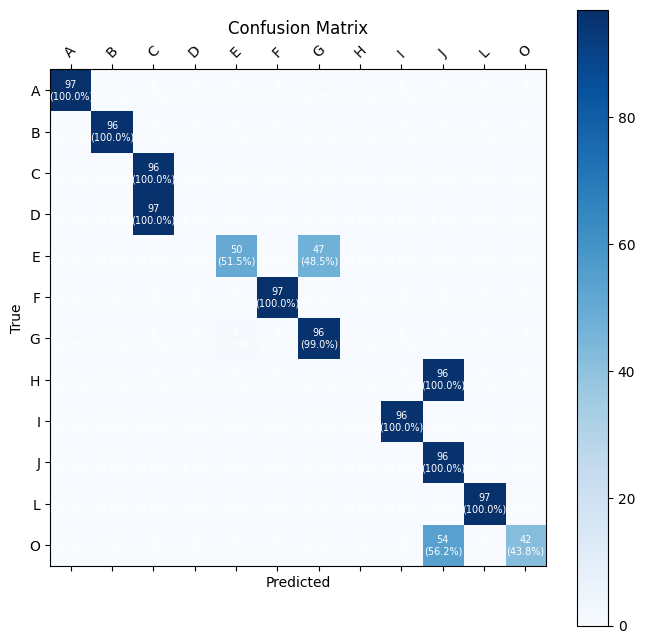

Model 1 - Accuracy: 0.996548748921484
Model 2 - Accuracy: 0.997411561691113
Model 3 - Accuracy: 0.9930974978429681
Model 4 - Accuracy: 0.9956859361518551
Model 5 - Accuracy: 0.998274374460742
Model 1 - Accuracy: 0.5656303972366149
Model 2 - Accuracy: 0.5267702936096719
Model 3 - Accuracy: 0.5440414507772021
Model 4 - Accuracy: 0.4948186528497409
Model 5 - Accuracy: 0.7469775474956822
Frequency: [370, 380, 390]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9870689655172413
Model 2 - Accuracy: 0.9793103448275862
Model 3 - Accuracy: 0.9758620689655172
Model 4 - Accuracy: 0.9801724137931035
Model 5 - Accuracy: 0.9836206896551725
Model 1 - Accuracy: 0.4369602763385147
Model 2 - Accuracy: 0.4948186528497409
Model 3 - Accuracy: 0.24352331606217617
Model 4 - Accuracy: 0.5457685664939551
Model 5 - Accuracy: 0.3696027633851468
Model 1 - Accuracy: 0.9801553062985332
Model 2 - Accuracy: 0.9784296807592753
Model 3 - Accuracy: 0.9456427955133736
Model 4 - Accuracy: 0.9810181190681622
Model 5 - Accuracy: 0.9818809318377912
Model 1 - Accuracy: 0.4784110535405872
Model 2 - Accuracy: 0.2651122625215889
Model 3 - Accuracy: 0.25302245250431776
Model 4 - Accuracy: 0.5466321243523317
Model 5 - Accuracy: 0.43609671848013815
Frequency: [400, 410, 420]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9862068965517241
Model 2 - Accuracy: 0.9810344827586207
Model 3 - Accuracy: 0.9818965517241379
Model 4 - Accuracy: 0.9844827586206897
Model 5 - Accuracy: 0.9853448275862069
Model 1 - Accuracy: 0.3221070811744387
Model 2 - Accuracy: 0.44473229706390327
Model 3 - Accuracy: 0.3333333333333333
Model 4 - Accuracy: 0.3920552677029361
Model 5 - Accuracy: 0.41968911917098445
Model 1 - Accuracy: 0.9784296807592753
Model 2 - Accuracy: 0.9706643658326143
Model 3 - Accuracy: 0.9283865401207938
Model 4 - Accuracy: 0.9758412424503883
Model 5 - Accuracy: 0.9792924935289042
Model 1 - Accuracy: 0.3436960276338515
Model 2 - Accuracy: 0.48704663212435234
Model 3 - Accuracy: 0.41018998272884283
Model 4 - Accuracy: 0.4231433506044905
Model 5 - Accuracy: 0.49654576856649396
Frequency: [430, 440, 450]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9758620689655172
Model 2 - Accuracy: 0.9724137931034482
Model 3 - Accuracy: 0.9568965517241379
Model 4 - Accuracy: 0.9724137931034482
Model 5 - Accuracy: 0.975
Model 1 - Accuracy: 0.48791018998272884
Model 2 - Accuracy: 0.5785837651122625
Model 3 - Accuracy: 0.4749568221070812
Model 4 - Accuracy: 0.5328151986183074
Model 5 - Accuracy: 0.5820379965457686
Model 1 - Accuracy: 0.9784296807592753
Model 2 - Accuracy: 0.9741156169111302
Model 3 - Accuracy: 0.902502157031924
Model 4 - Accuracy: 0.9698015530629853
Model 5 - Accuracy: 0.9801553062985332
Model 1 - Accuracy: 0.4637305699481865
Model 2 - Accuracy: 0.5414507772020726
Model 3 - Accuracy: 0.33592400690846286
Model 4 - Accuracy: 0.4317789291882556
Model 5 - Accuracy: 0.39896373056994816
Frequency: [460, 470, 480]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9551724137931035
Model 2 - Accuracy: 0.9603448275862069
Model 3 - Accuracy: 0.9560344827586207
Model 4 - Accuracy: 0.9491379310344827
Model 5 - Accuracy: 0.9603448275862069
Model 1 - Accuracy: 0.38946459412780654
Model 2 - Accuracy: 0.48272884283246975
Model 3 - Accuracy: 0.34628670120898103
Model 4 - Accuracy: 0.32556131260794474
Model 5 - Accuracy: 0.5198618307426598
Model 1 - Accuracy: 0.9706643658326143
Model 2 - Accuracy: 0.9646246764452114
Model 3 - Accuracy: 0.9249352890422778
Model 4 - Accuracy: 0.9715271786022434
Model 5 - Accuracy: 0.9680759275237274
Model 1 - Accuracy: 0.4110535405872193
Model 2 - Accuracy: 0.33506044905008636
Model 3 - Accuracy: 0.3765112262521589
Model 4 - Accuracy: 0.4430051813471503
Model 5 - Accuracy: 0.5250431778929189
Frequency: [490, 500, 510]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9482758620689655
Model 2 - Accuracy: 0.9422413793103448
Model 3 - Accuracy: 0.9405172413793104
Model 4 - Accuracy: 0.9431034482758621
Model 5 - Accuracy: 0.9551724137931035
Model 1 - Accuracy: 0.4067357512953368
Model 2 - Accuracy: 0.33506044905008636
Model 3 - Accuracy: 0.344559585492228
Model 4 - Accuracy: 0.3842832469775475
Model 5 - Accuracy: 0.39896373056994816
Model 1 - Accuracy: 0.9016393442622951
Model 2 - Accuracy: 0.903364969801553
Model 3 - Accuracy: 0.8386540120793787
Model 4 - Accuracy: 0.8981880931837791
Model 5 - Accuracy: 0.917169974115617
Model 1 - Accuracy: 0.44905008635578586
Model 2 - Accuracy: 0.6347150259067358
Model 3 - Accuracy: 0.4680483592400691
Model 4 - Accuracy: 0.5449050086355786
Model 5 - Accuracy: 0.6312607944732297
Frequency: [520, 530, 540]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.8068965517241379
Model 2 - Accuracy: 0.8189655172413793
Model 3 - Accuracy: 0.8112068965517242
Model 4 - Accuracy: 0.8120689655172414
Model 5 - Accuracy: 0.8232758620689655
Model 1 - Accuracy: 0.34974093264248707
Model 2 - Accuracy: 0.3393782383419689
Model 3 - Accuracy: 0.3385146804835924
Model 4 - Accuracy: 0.3436960276338515
Model 5 - Accuracy: 0.34024179620034545
Model 1 - Accuracy: 0.8119068162208801
Model 2 - Accuracy: 0.8213977566867989
Model 3 - Accuracy: 0.8024158757549612
Model 4 - Accuracy: 0.8075927523727351
Model 5 - Accuracy: 0.8248490077653149
Model 1 - Accuracy: 0.43523316062176165
Model 2 - Accuracy: 0.4162348877374784
Model 3 - Accuracy: 0.4620034542314335
Model 4 - Accuracy: 0.42573402417962003
Model 5 - Accuracy: 0.41796200345423146
Frequency: [550, 560, 570]


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.6267241379310344
Model 2 - Accuracy: 0.6448275862068965
Model 3 - Accuracy: 0.6456896551724138
Model 4 - Accuracy: 0.6275862068965518
Model 5 - Accuracy: 0.6448275862068965
Model 1 - Accuracy: 0.40846286701208984
Model 2 - Accuracy: 0.40500863557858374
Model 3 - Accuracy: 0.4119170984455959
Model 4 - Accuracy: 0.40932642487046633
Model 5 - Accuracy: 0.40414507772020725
Model 1 - Accuracy: 0.6203623813632442
Model 2 - Accuracy: 0.6177739430543572
Model 3 - Accuracy: 0.5815358067299397
Model 4 - Accuracy: 0.5901639344262295
Model 5 - Accuracy: 0.6212251941328731
Model 1 - Accuracy: 0.4317789291882556
Model 2 - Accuracy: 0.4231433506044905
Model 3 - Accuracy: 0.37823834196891193
Model 4 - Accuracy: 0.39291882556131263
Model 5 - Accuracy: 0.4309153713298791
Frequency: [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 50

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
c:\Users\Dani - TUF\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model 1 - Accuracy: 0.9974137931034482
Model 2 - Accuracy: 0.9974137931034482
Model 3 - Accuracy: 0.996551724137931
Model 4 - Accuracy: 0.9948275862068966
Model 5 - Accuracy: 0.9982758620689656
Model 1 - Accuracy: 0.3955094991364421
Model 2 - Accuracy: 0.5440414507772021
Model 3 - Accuracy: 0.34110535405872194
Model 4 - Accuracy: 0.4015544041450777
Model 5 - Accuracy: 0.4991364421416235
Model 1 - Accuracy: 0.993960310612597
Model 2 - Accuracy: 0.9870578084555651
Model 3 - Accuracy: 0.9922346850733391
Model 4 - Accuracy: 0.99137187230371
Model 5 - Accuracy: 0.996548748921484
Model 1 - Accuracy: 0.5328151986183074
Model 2 - Accuracy: 0.3160621761658031
Model 3 - Accuracy: 0.34110535405872194
Model 4 - Accuracy: 0.41018998272884283
Model 5 - Accuracy: 0.34110535405872194


In [ ]:
csv_path = os.path.normpath(os.path.join(notebook_dir, '..', '..', '..', 'data/results/exp_5/75_testing_results_12p.csv'))

# Training options
drop_sample = True
eliminate_std_dev = False
eliminate_LG = True
HG_diff = False
LG_diff = False
apply_scaling = False
apply_savitzky_golay = True
apply_pca = False
apply_pca = True
apply_pca = True
apply_lda = False 
apply_qda = False
apply_ica = False


print(f'Training')

for freq in freqs:

    subset_freqs = freq
    print(f'Frequency: {freq}')
    
    X_train, y_train = preprocess_data(train_set_test, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True) 
    X_test, y_test = preprocess_data(test_set_test, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True)

    X_train = add_features(X_train, y_train, subset_freqs, HG_diff, LG_diff)
    X_test = add_features(X_test, y_test, subset_freqs, HG_diff, LG_diff)

    # Apply standard scaling
    if apply_scaling:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    if apply_savitzky_golay:
        X_train = savgol_filter(X_train, window_length=5, polyorder=3)
        X_test = savgol_filter(X_test, window_length=5, polyorder=3)

    if apply_pca:
        pca = PCA()
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    if apply_lda:
        lda = LinearDiscriminantAnalysis()
        X_train = lda.fit_transform(X_train, y_train)
        X_test = lda.transform(X_test)

    if apply_qda:
        qda = QuadraticDiscriminantAnalysis()
        qda.fit(X_train, y_train)
        # Get probability estimates
        X_train_qda = qda.predict_proba(X_train)
        X_test_qda = qda.predict_proba(X_test)
        
        # If you want to combine with original features
        X_train = np.hstack((X_train, X_train_qda))
        X_test = np.hstack((X_test, X_test_qda))

    if apply_ica:
        ica = FastICA(n_components=2)
        X_train = ica.fit_transform(X_train)
        X_test = ica.transform(X_test)

    # Define model names
    models = ['RF', 'NB', 'LR', 'GB', 'SVM']

    # Train the models
    rf_model, nb_model, lr_model, gb_model, svm_model = train_models(X_train, y_train, seed)

    # Make Predictions
    y_pred = [
        rf_model.predict(X_test),
        nb_model.predict(X_test),
        lr_model.predict(X_test),
        gb_model.predict(X_test),
        svm_model.predict(X_test)
        ]
    ]
        
    # Evaluate Models
    accuracies, precisions, recalls, f1_scores, aic_scores, bic_scores, predictions = evaluate_models(y_test, y_pred, verbose=0)

    updated_results = save_model_results(
        models=models,
        data='test',
        accuracies=accuracies,
        precisions=precisions,
        recalls=recalls,
        f1_scores=f1_scores,
        aic_scores=aic_scores,
        bic_scores=bic_scores,
        predictions=predictions,
        n_features=X_train.shape[1],
        freqs=subset_freqs,
        csv_path=csv_path
    )


    X_new_sample, y_new_sample = preprocess_data(df_new_sample, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True)

    X_new_sample = add_features(X_new_sample, y_new_sample, subset_freqs, HG_diff, LG_diff)


    if apply_scaling:
        X_new_sample = scaler.transform(X_new_sample)

    if apply_savitzky_golay:
        X_new_sample = savgol_filter(X_new_sample, window_length=5, polyorder = 3)

    if apply_pca:
        X_new_sample = pca.transform(X_new_sample)

    if apply_qda:
        X_new_sample_qda = qda.predict_proba(X_new_sample)
        X_new_sample = np.hstack((X_new_sample, X_new_sample_qda))
                                  
    if apply_lda:
        X_new_sample = lda.transform(X_new_sample)

    if apply_ica:
        X_new_sample = ica.transform(X_new_sample)

    # Make Predictions
    y_pred_ns = [
        rf_model.predict(X_new_sample),
        nb_model.predict(X_new_sample),
        lr_model.predict(X_new_sample),
        gb_model.predict(X_new_sample),
        svm_model.predict(X_new_sample)
        ]

    # Evaluate Models
    accuracies, precisions, recalls, f1_scores, aic_scores, bic_scores, predictions = evaluate_models(y_new_sample, y_pred_ns, verbose=0)

    # Plot Confusion Matrix of good models
    for i, accuracy in enumerate(accuracies):
        if accuracy >= 0.75:
            plot_confusion_matrix(y_new_sample, y_pred_ns[i], np.unique(y_train))


    updated_results = save_model_results(
        models=models,
        data='new_sample',
        accuracies=accuracies,
        precisions=precisions,
        recalls=recalls,
        f1_scores=f1_scores,
        aic_scores=aic_scores,
        bic_scores=bic_scores,
        predictions=predictions,
        n_features=X_train.shape[1],
        freqs=subset_freqs,
        csv_path=csv_path
    )


In [72]:
config = dict(
    epochs=25,
    seed = 42,
    classes = labels,
    batch_size=32,
    sequence_length = 1, #Check
    learning_rate=0.00005,
    dataset="experiment_1",
    architecture="LSTM",
    hidden_dim = 128
    )

print(config)

{'epochs': 25, 'seed': 42, 'classes': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'O'], 'batch_size': 32, 'sequence_length': 1, 'learning_rate': 5e-05, 'dataset': 'experiment_1', 'architecture': 'LSTM', 'hidden_dim': 128}


### Principal Component Analysis

Frequency: [250, 300, 320]


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/results/pca_models/pca_viz_250_300_320.pdf'

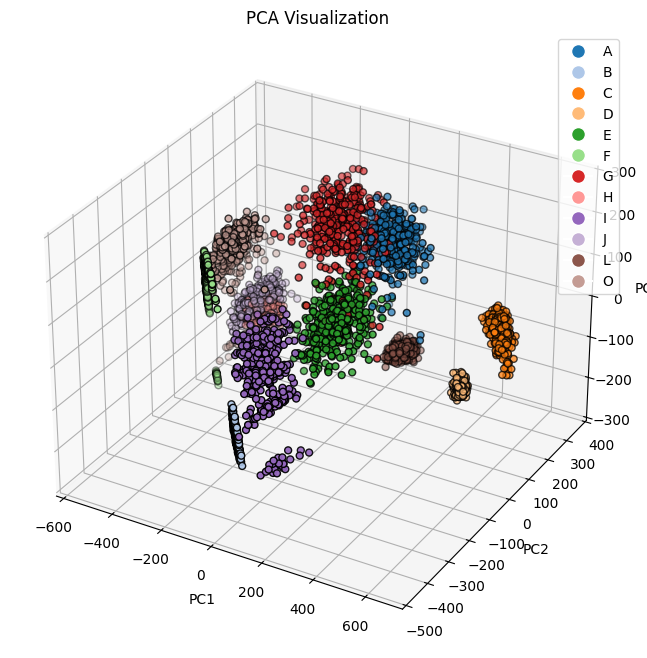

In [ ]:
# PCA 3D Visualization 
def plot_pca_3d(X_train_pca, y_pca):
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_pca)
    n_classes = len(np.unique(y_encoded))
    
    # Create colormap
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    colors = colors[:n_classes]
    custom_cmap = plt.cm.colors.ListedColormap(colors)
    
    # Get number of components
    n_components = X_train_pca.shape[1]
    fig = plt.figure(figsize=(10, 8))
    
    if n_components >= 3:
        # 3D plot
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X_train_pca[:, 0], 
                           X_train_pca[:, 1],
                           X_train_pca[:, 2],
                           c=y_encoded,
                           cmap=custom_cmap,
                           edgecolor='k',
                           s=25)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        
    elif n_components == 2:
        # 2D plot
        ax = fig.add_subplot(111)
        scatter = ax.scatter(X_train_pca[:, 0],
                           X_train_pca[:, 1],
                           c=y_encoded,
                           cmap=custom_cmap,
                           edgecolor='k',
                           s=25)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        
    else:
        # 1D plot
        ax = fig.add_subplot(111)
        scatter = ax.scatter(X_train_pca[:, 0],
                           np.zeros_like(X_train_pca[:, 0]),
                           c=y_encoded,
                           cmap=custom_cmap,
                           edgecolor='k',
                           s=25)
        ax.set_xlabel('PC1')
        plt.yticks([])
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0],
                                marker='o',
                                color='w', 
                                markerfacecolor=custom_cmap(i),
                                label=class_name,
                                markersize=10)
                      for i, class_name in enumerate(le.classes_)]
    
    plt.legend(handles=legend_elements)
    plt.title(f'PCA Visualization')

    # Save image as pdf
    filepath  = os.path.normpath(os.path.join(notebook_dir, '..', '..', '..', 'data/results/exp_5/70_testing_results_12p.csv'))

    filepath ='C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/results/pca_models/'
    freqs_code = '_'.join(map(str, subset_freqs))
    plt.savefig(f'{filepath}pca_viz_{freqs_code}.pdf')
    plt.show()


# PCA 3D Visualization
for freq in freqs:

    subset_freqs = freq
    print(f'Frequency: {freq}')

    X_train, y_train = preprocess_data(train_set_test, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True) 
    X_test, y_test = preprocess_data(test_set_test, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True)

    X_train = add_features(X_train, y_train, subset_freqs, HG_diff, LG_diff)
    X_test = add_features(X_test, y_test, subset_freqs, HG_diff, LG_diff)

    pca = PCA(n_components=0.95)  
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    y_pca = y_train
    
    plot_pca_3d(X_train_pca, y_pca)

    # Save PCA model
    # Create data dictionary
    pca_data = {
        'X_transformed': X_train_pca,
        'wavelengths': subset_freqs,
        'labels': y_pca,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'feature_names': ['340 GHz', '350 GHz', '360 GHz']
    }

    # # Save image as pdf
    # filepath ='C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/results/pca_models/'

    # freqs_code = '_'.join(map(str, subset_freqs))
    # plt.savefig(f'{filepath}pca_viz_{freqs_code}.pdf')



    # # Save complete dataset to a pickle file for 3D visualization
    # freqs_code = '_'.join(map(str, subset_freqs))
    # with open(f'pca_models/pca_viz_{freqs_code}.pkl', 'wb') as f:
    #     pickle.dump(pca_data, f)

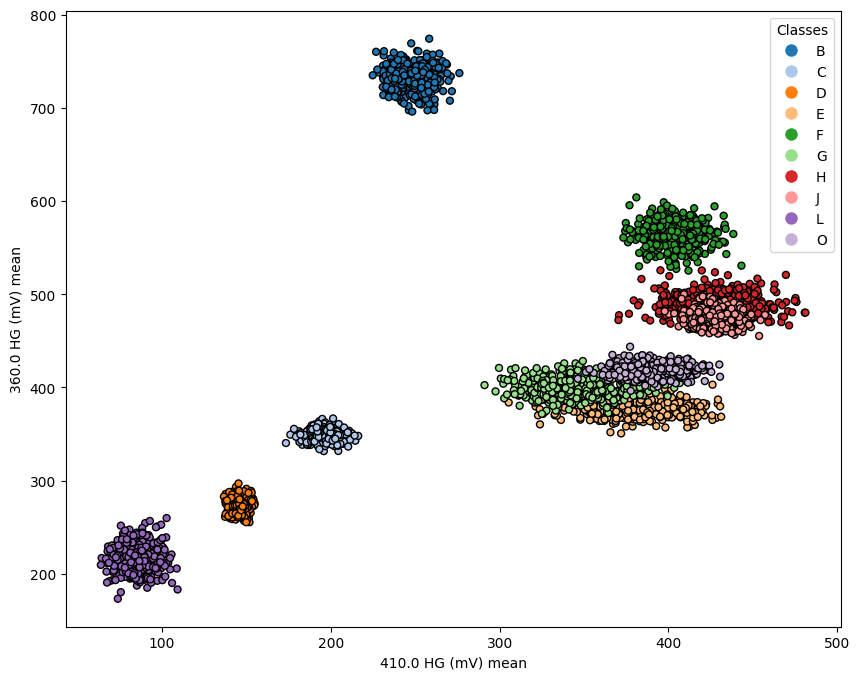

In [ ]:
subset_freqs = list(range(100, 600, 10))

X_train, y_train = preprocess_data(train_set_test, labels, subset_freqs, eliminate_std_dev, eliminate_LG, drop_sample=True)
X_train = add_features(X_train, y_train, subset_freqs, HG_diff, LG_diff)

## NON PCA VISUALIZATION ##
# Choose specific variables for visualization
var1 = '410.0 HG (mV)'
var2 = '360.0 HG (mV)'

try:
    X_train[var1].describe()
except Exception as e:
    var1 = f'{var1} mean'
    var2 = f'{var2} mean'

def plot_data_visualization(X_train, y_train, var1, var2):
    
    # Get unique classes and encode
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_train)
    n_classes = len(np.unique(y_encoded))
    
    # Create custom colormap with only needed colors
    colors = plt.cm.tab20(np.linspace(0, 1, 20))  # Get all 20 colors
    colors = colors[:n_classes]  # Take only needed colors
    custom_cmap = plt.cm.colors.ListedColormap(colors)
    
    # Create plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_train[var1], 
                         X_train[var2],
                         c=y_encoded,
                         cmap=custom_cmap,
                         edgecolor='k', 
                         s=25)
    
    # Create custom legend
    legend_elements = [plt.Line2D([0], [0], 
                                marker='o', 
                                color='w',
                                markerfacecolor=colors[i], 
                                label=class_name,
                                markersize=10) 
                      for i, class_name in enumerate(le.classes_)]
    
    plt.legend(handles=legend_elements, title="Classes")
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.show()

plot_data_visualization(X_train, y_train, var1, var2)